In [58]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import corner
import warnings
import seaborn as sns
pd.options.display.float_format = '{:.5f}'.format
pd.set_option('display.max_columns', 500)
warnings.filterwarnings('ignore')
# jupyter nbconvert --to html  ex1.ipynb

Michael Kuznetsov 342522745
Elisha Diskind 298782656

## Q1+Q2


We are choosing the data set of all FIFA (the game) players with their stats (FIFA player measurements). We can learn a lot from this df and we want to see if there is some relations between the stats.

In [59]:
fifa_df=pd.read_csv("FIFA17_official_data.csv")

# Deleting all goalkeepers (GK position) cause their stats are quite different from other players.
fifa_df=fifa_df[fifa_df["Best Position"]!= "GK"]

FIFA df has a lot of columns, so we will keep only columns that we think are relevant for us. Some columns we have deleted because we don't know what is the meaning of them, some were related to goalkeepers that we have deleted from data set
and a lot of columns are irrelevant to our job. <br>
In particular, our first explained variable will be "Overall" that is how many points out of 100 the FIFA game has given to some particular player and second one is "Value" that shows the price for some player. <br>
We want to check if our features has relation to Overall variable and if so how strong it is.

In [60]:
fifa_subset = fifa_df[['Age', 'Overall', 'Value','ShortPassing',
       'LongPassing', 'SprintSpeed', 'ShotPower',
       'LongShots', 'Positioning', 'StandingTackle', 'SlidingTackle','Best Position']]


In [61]:
# Delete the players with Value = 0
fifa_subset = fifa_subset[fifa_subset["Value"]!="€0"]

In [62]:
# Let's take a look on the clean data set
fifa_subset

,Age,Overall,Value,ShortPassing,LongPassing,SprintSpeed,ShotPower,LongShots,Positioning,StandingTackle,SlidingTackle,Best Position
0,29,92,€83M,83.00000,64.00000,77.00000,87.00000,86.00000,92.00000,45.00000,38.00000,ST
1,28,86,€37.5M,84.00000,81.00000,78.00000,84.00000,86.00000,88.00000,85.00000,88.00000,CDM
2,29,87,€41.5M,84.00000,82.00000,74.00000,84.00000,85.00000,80.00000,89.00000,84.00000,CDM
3,24,86,€41.5M,83.00000,80.00000,86.00000,83.00000,83.00000,77.00000,83.00000,83.00000,LB
4,23,88,€71.5M,85.00000,88.00000,79.00000,90.00000,87.00000,84.00000,73.00000,73.00000,CAM
...,...,...,...,...,...,...,...,...,...,...,...,...
16261,18,49,€60K,38.00000,34.00000,42.00000,35.00000,21.00000,25.00000,48.00000,47.00000,CB
16299,28,56,€90K,33.00000,35.00000,34.00000,39.00000,28.00000,17.00000,56.00000,50.00000,CB
16454,18,54,€130K,36.00000,47.00000,62.00000,31.00000,22.00000,18.00000,50.00000,49.00000,CB
16465,17,48,€60K,30.00000,20.00000,54.00000,38.00000,17.00000,24.00000,48.00000,50.00000,CB


In [63]:
# Changing the "Value" to the one we could make regression on (€83K = 0.083, €10.5M = 10.5 etc.)
def make_valeu_float(val):
    multiplier = {"K": 1000/1000000, "M": 1}
    return float(val[1:-1])*multiplier[val[-1]]
fifa_subset["Value"] = fifa_subset["Value"].apply(lambda x: make_valeu_float(x))

In [64]:
# Check if we are having NA's and if so - how much in each column

fifa_subset.isna().sum()

Age               0
Overall           0
Value             0
ShortPassing      0
LongPassing       0
SprintSpeed       0
ShotPower         0
LongShots         0
Positioning       0
StandingTackle    0
SlidingTackle     0
Best Position     0
dtype: int64

Age: This refers to the player's age in years, and is an important factor in evaluating a player's potential and experience. <br>

Overall: This is a rating given to a player based on their overall skill level and performance in various aspects of the game. It is used to compare and rank players against each other. <br>

Value: This is the estimated market value of a player, which takes into account different factors . It is often used as a reference point for player transfers and negotiations. <br>

ShortPassing: This refers to the player's ability to accurately pass the ball over short distances, typically within a few meters. <br>

LongPassing: This refers to the player's ability to accurately pass the ball over longer distances, typically over 10-20 meters or more. <br>

SprintSpeed: This refers to the player's ability to run at high speeds over short distances, typically over 20-30 meters or less. <br>

ShotPower: This refers to the player's ability to shoot the ball with power and accuracy, typically measured by the speed of the shot and the force behind it. <br>

LongShots: This refers to the player's ability to take shots from a distance, typically outside the penalty box. <br>

Positioning: This refers to the player's ability to position themselves effectively on the field, both offensively and defensively. <br>

StandingTackle: This refers to the player's ability to make tackles while standing, typically used to stop an opposing player from advancing with the ball. <br>

SlidingTackle: This refers to the player's ability to make tackles while sliding on the ground, typically used to stop an opposing player from advancing with the ball. <br>

Best Position: This refers to the player's primary or preferred position on the field, such as forward, midfielder, defender, or goalkeeper (that we have removed). It is often used to evaluate a player's suitability for different team formations and strategies.

So our features mostly are some important stats for football player as his speed, passes, shoots and tackling for example, and also "Age" and "Best position" that can have impact in theory on the "Overall" or "Value".

## Q3

We can assume that some features can be correlated one with another: <br>
Short with long passing; Shot power with Long shots; Standing Tackle (how good the player is to defend in standing position) with Sliding Tackle (to defending when the player is running after attacker).

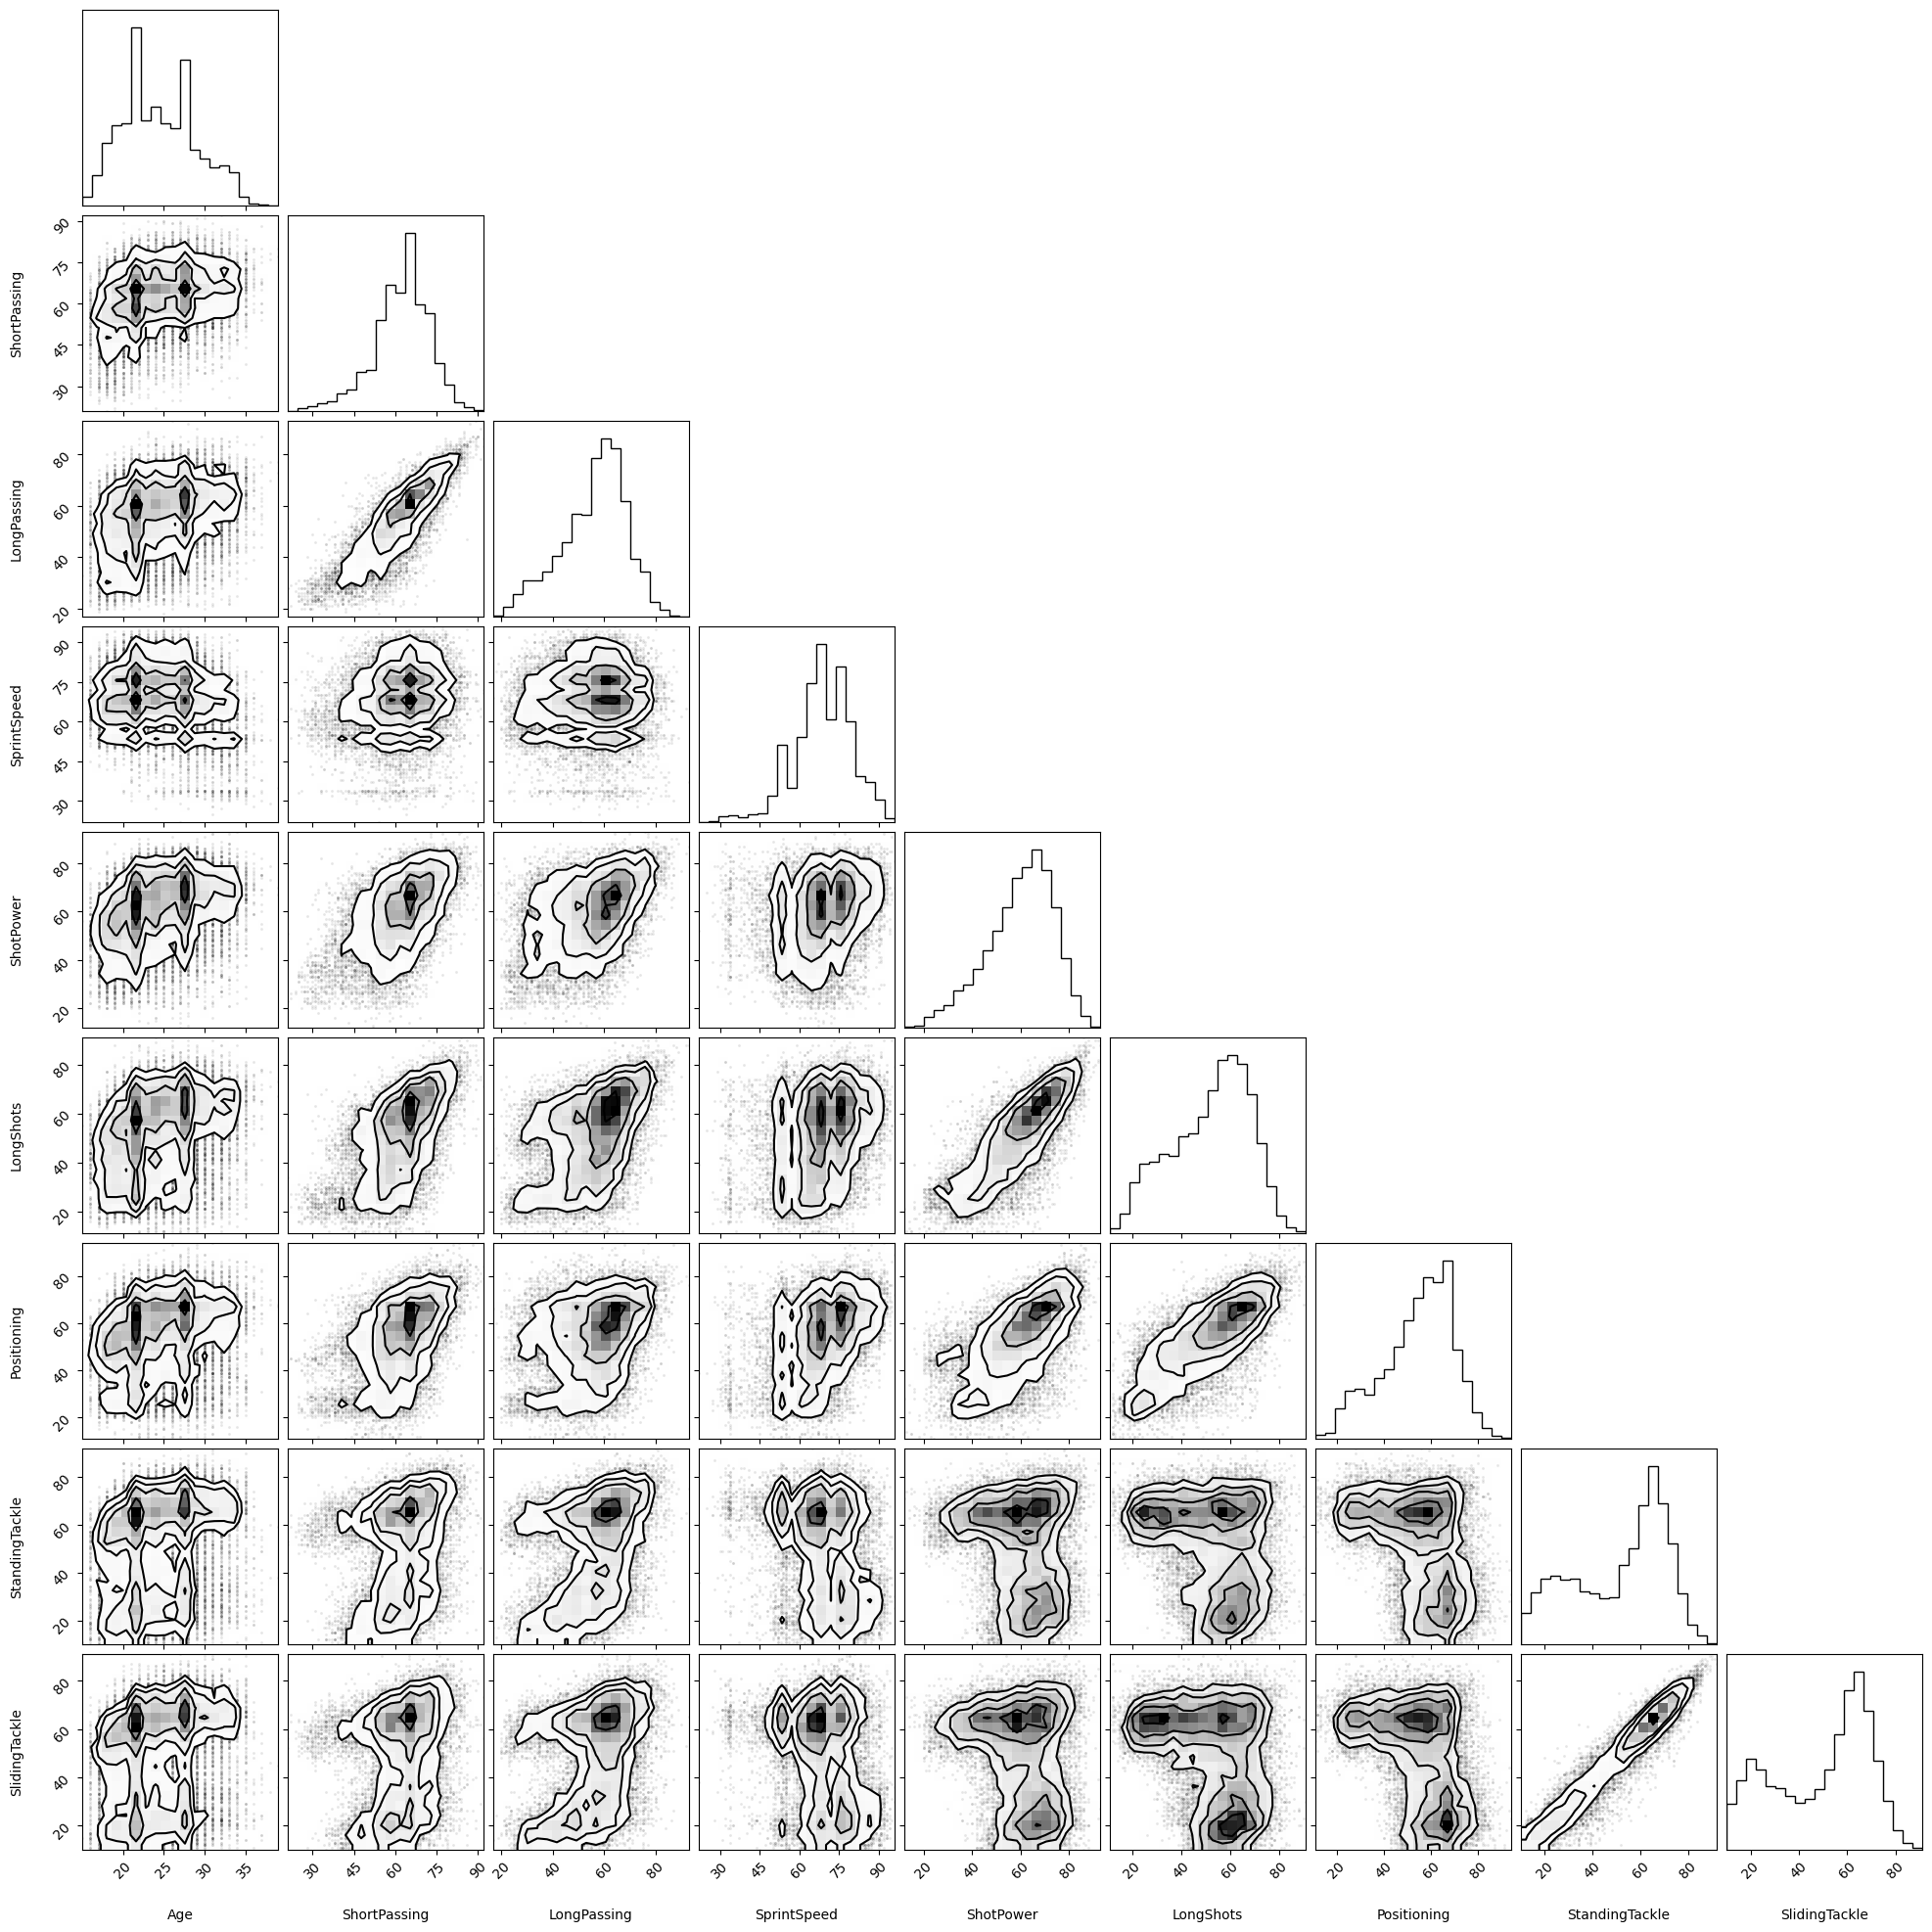

In [65]:
corcor=corner.corner(fifa_subset.drop(columns=["Best Position", "Value", "Overall"]), labels=fifa_subset.drop(columns=["Best Position", "Value", "Overall"]).columns)

corcor.show()

So what we can see on the "corner.corner" panels? <br>
The diagonal of the plots in a corner figure shows the distribution of each variable in the dataset using a histogram. Each histogram represents the frequency distribution of the corresponding variable. <br>
The plots below the diagonal show scatter plots of pairs of variables, with the variable on the y-axis plotted against the variable on the x-axis. <br> These scatter plots show the pairwise relationships between the variables. <br>
At the end these plots can help us to imagine what are relations between the variables.

As we can see by the shapes: <br>
ShortPassing and LongPassing seems to have strong correlation <br>
ShortPassing and ShotPower seems to have correlation <br>
LongPassing and ShotPower seems to have correlation <br>
ShotPower and LongShot seems to have strong correlation <br>
ShotPower and Positioning seems to have correlation <br>
LongShots and Positioning seems to have correlation <br>
StandingTackle and SlidingTackle seems to have strong correlation

## Q4

In [66]:
# Load the dataset into a pandas DataFrame
df = pd.read_csv('dataset.csv')

# Extract the first column as the explained variable and the remaining columns as the explanatory variables
y = df.iloc[:, 0]
X = df.iloc[:, 1:]
# Add a constant term to the explanatory variables
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()
p_values = results.pvalues

In [67]:
# Let's take a look on p_values in decreasing order:
print(p_values.sort_values(ascending=False))

x9      0.93058
x16     0.91245
x13     0.84537
x22     0.81451
x17     0.67945
x21     0.63484
x5      0.43359
x15     0.42290
x18     0.31476
x10     0.28893
x14     0.25336
const   0.16588
x2      0.16261
x23     0.14030
x1      0.08981
x4      0.08544
x12     0.04736
x8      0.01692
x7      0.00313
x11     0.00003
x24     0.00000
x3      0.00000
x6      0.00000
x19     0.00000
x20     0.00000
dtype: float64


These p_values show us what is the chance that our H0(null hypothesis) will be declined, where H0 is hypothesis that this specific feature has no influence on our label *y* (there is no relationship between two variables), that means that *beta* = 0.
<br>
<br>
If the p-value is low, typically less than 0.05, it is considered evidence against the H0 and suggests that the result is statistically significant.
<br>
Looking at the list of p-values, we can see that the p-values less than 0.05 are associated with x3, x6, x7, x11, x19, x20, and x24. The other p-values are higher, indicating that the evidence against the H0 is weaker, and they may not be statistically significant.

## Q5

In [68]:
# Function of backward elimination until no further improvements in adjusted R-squared are observed
def backward_elim(X, y):
    # Initialize a list to store the names of the removed columns
    removed_cols = []
    model = sm.OLS(y, X)
    results = model.fit()
    prev_adj_r_squared = results.rsquared_adj
    while True:
        # Initialize a list to store the adjusted R-squared values for each column
        adj_r_squareds = []

        # Loop over the explanatory variables and calculate the adjusted R-squared for each column after removing it
        for col in X.columns[1:]:
            X_subset = X.drop(columns=[col])
            model = sm.OLS(y, X_subset)
            results = model.fit()
            adj_r_squared = results.rsquared_adj
            adj_r_squareds.append(adj_r_squared)

        # Find the index of column that dropping of this column leads to the highest adjusted R-squared.
        best_col_idx = adj_r_squareds.index(max(adj_r_squareds))

        # If the adjusted R-squared has improved, remove the corresponding column and refit the model
        if max(adj_r_squareds) > prev_adj_r_squared:
            removed_col = X.columns[best_col_idx+1] # +1 because of const
            X = X.drop(columns=[removed_col])
            removed_cols.append(removed_col)
            model = sm.OLS(y, X)
            results = model.fit()
            prev_adj_r_squared = results.rsquared_adj
    # If the adjusted R-squared has not improved, stop removing columns
        else:
            break
    saved_cols = X.columns
    return removed_cols, saved_cols

In [69]:
res = backward_elim(X,y)
print("Features that were kept after elimination : ", list(res[1]))

Features that were kept after elimination :  ['const', 'x1', 'x2', 'x3', 'x4', 'x6', 'x7', 'x8', 'x11', 'x12', 'x14', 'x18', 'x19', 'x20', 'x23', 'x24']


We can see  the features columns that were kept in the model at the end there are columns that have low p_values. The max p_value that was kept is (x18) 0.31476, so why? Because as was mentioned before as bigger p_value is as higher is the chance that there is no influence of this specific feature on *y*, therefore it is pretty expected that the columns that we will delete are the features with the highest p_value!<br>
But we can see that x10 wasn't kept despite the fact that it's p_value is lower than x18, so we can assume that it is linear combination of other columns that we kept and therefore after elimination it was deleted.

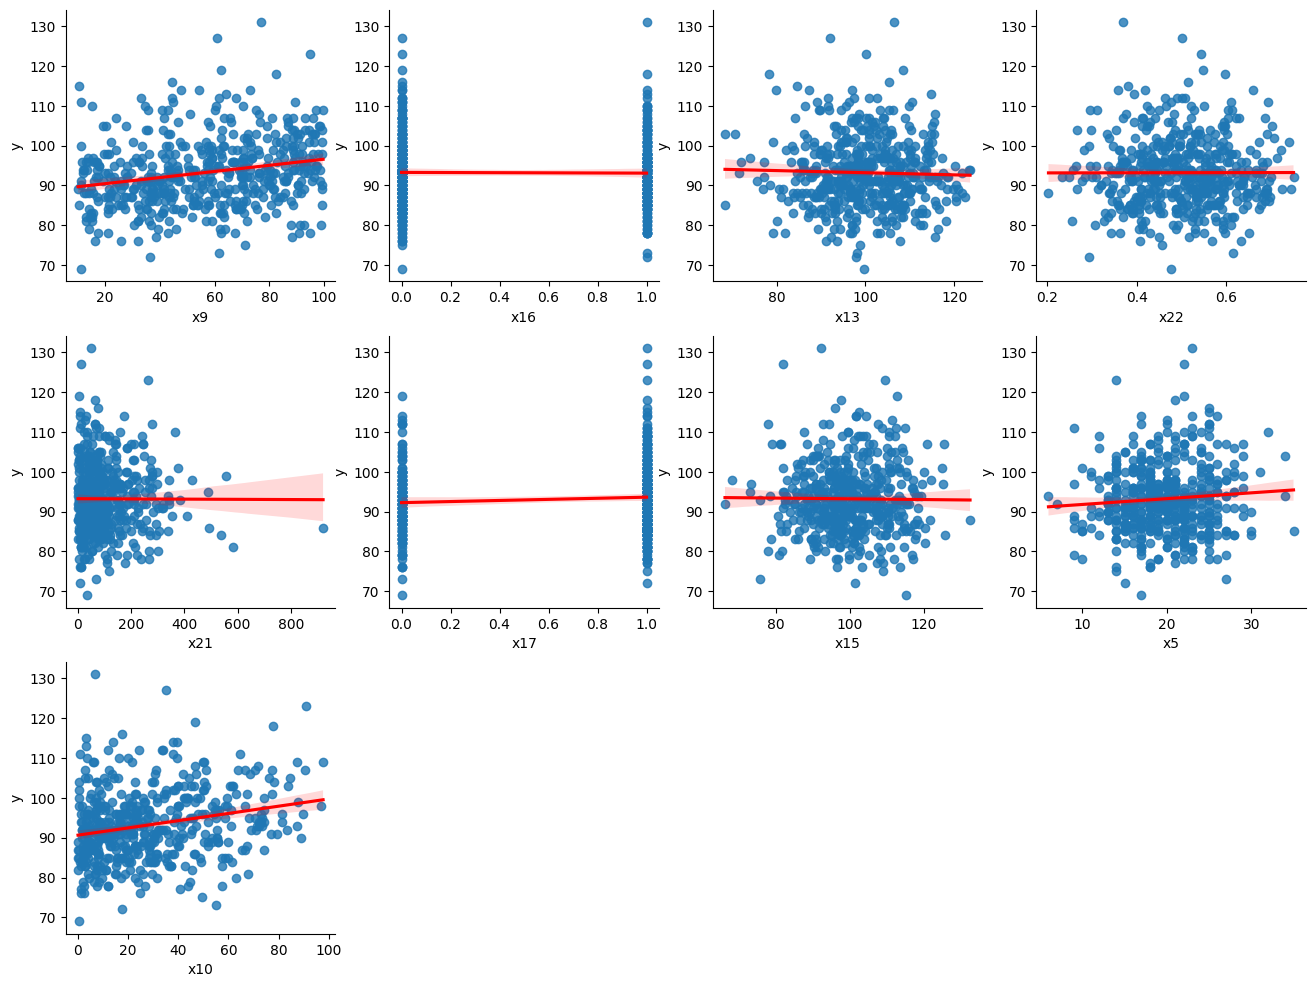

In [70]:
# Plot the columns that were removed
fig, axs = plt.subplots(nrows=(len(res[0]) + 3) // 4, ncols=4, figsize=(16, 4*(len(res[0]) + 3) // 4))
for i, col in enumerate(res[0]):
    row, col_idx = divmod(i, 4)
    sns.regplot(data=df, x=col, y=df.columns[0], ax=axs[row, col_idx], line_kws={'color': 'red'})

    axs[row, col_idx].set_xlabel(col)
    axs[row, col_idx].set_ylabel(df.columns[0])
    axs[row, col_idx].spines['right'].set_visible(False)
    axs[row, col_idx].spines['top'].set_visible(False)

# Remove unused subplots
while i < len(axs.flat) - 1:
    axs.flatten()[i+1].remove()
    i += 1

plt.show()

On the plots where y-axis is *y* (explained variable) and on x-axis some different features that were dropped we can clearly see on the most plots absence of any correlation with *y*. We understand that from the "cloud" form of the plot. <br>
Also, we can see 2 plots with dummy features and also there is clearly no connection between the feature and *y*. The reason of this conclusion is that no matter if dummy variable is 0 or 1 - the distribution of *y* looks pretty the same. <br>
All this means that there is no (or very little) correlation between these features and explained variable *y*.<br>

Probably as we can see with x9 for example there is some significant linear dependency, but if we would look on p_value that was 0.93058 we can assume that x9 was is linear combination of other features therefore p_value was very high in the full model.